In [21]:
!nvidia-smi

Wed Jul  3 10:56:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |   1155MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pwd

/content


In [3]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DRIVE_URL=f"/content/drive/My Drive/gsoc_images"

In [5]:
%cd {DRIVE_URL}
!cp images.zip /content/images.zip
!cp rkd_keys.csv /content/rkd_keys.csv
%cd /content/

/content/drive/My Drive/gsoc_images
/content


In [0]:
!unzip -q images.zip

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
np.random.seed(2)

In [0]:
def trim_df(df):
    df['IC1'] = df['Iconclass'].str[:3]
    df = df.groupby('Id').agg({'Iconclass':','.join,'IC1':set}).reset_index()
    df['IC1'] = df['IC1'].str.join(',')
    df["IMG"] = df["Id"].astype(str).__add__(".jpg")
    return df

In [0]:
df = trim_df(pd.read_csv("rkd_keys.csv")[['Iconclass','Id']])

In [0]:
PATH = f"./images"

In [12]:
df[:20]

,Id,Iconclass,IC1,IMG
0,1,73B8,73B,1.jpg
1,79,73B57,73B,79.jpg
2,95,73C8643,73C,95.jpg
3,106,"73D414,73D415",73D,106.jpg
4,108,73B57,73B,108.jpg
5,109,73D94,73D,109.jpg
6,113,73B732,73B,113.jpg
7,135,73D71,73D,135.jpg
8,143,73C11,73C,143.jpg
9,160,73E77,73E,160.jpg


In [0]:
src = ImageList.from_df(df[['IMG','IC1']],PATH).split_by_rand_pct().label_from_df(label_delim=',')

In [0]:
data = src.transform(get_transforms(max_rotate=2.0,max_warp=0.0), size=128).databunch(bs=256)

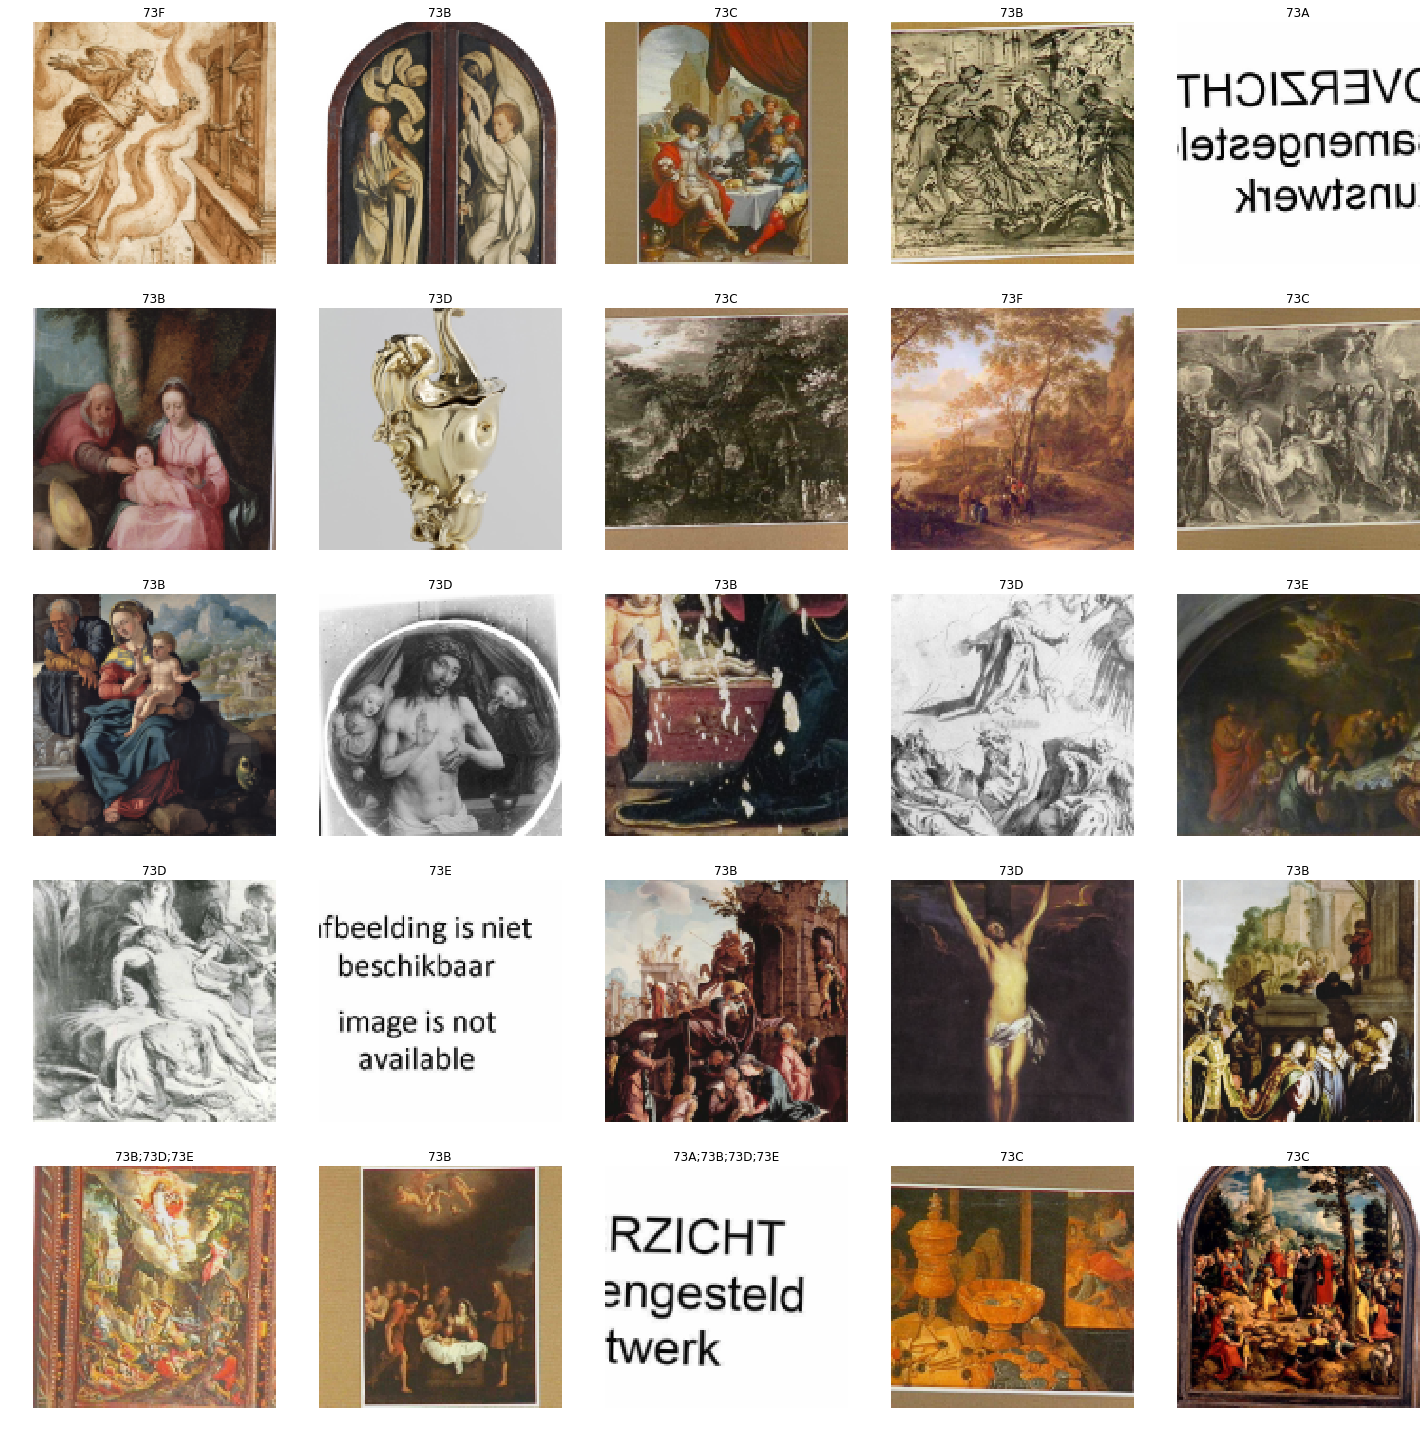

In [24]:
data.show_batch()

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data,arch,pretrained=True, metrics=[acc_02, f_score])

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


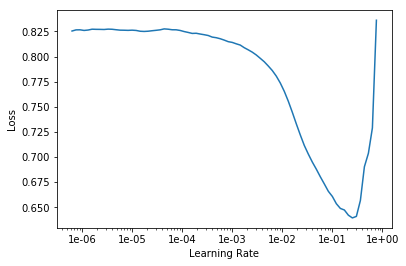

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10,slice(3e-2//3,3e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.551767,0.299722,0.861986,0.387911,02:04
1,0.371847,0.273235,0.818582,0.555122,02:03
2,0.309862,0.261224,0.831868,0.594623,02:03
3,0.277345,0.255534,0.845201,0.597232,02:02
4,0.257180,0.251000,0.842648,0.603113,02:01
5,0.244970,0.245934,0.835083,0.625661,02:01
6,0.232790,0.243539,0.857967,0.607061,02:01
7,0.221846,0.240947,0.858723,0.618570,02:01
8,0.213453,0.237870,0.858109,0.625608,02:01
9,0.206424,0.237384,0.862175,0.625822,02:02


In [30]:
%cd {DRIVE_URL}
learn.save(f'RKD1_frozen_2fb0625b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [40]:
%cd {DRIVE_URL}
learn = learn.load(f'RKD1_frozen_2fb0625b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


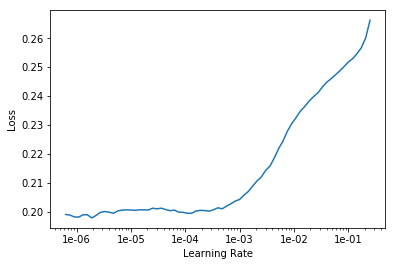

In [42]:
learn.lr_find()
learn.recorder.plot()

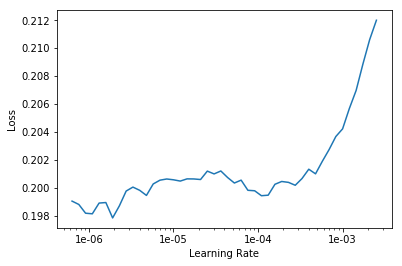

In [43]:
learn.recorder.plot(skip_end=30)

In [44]:
learn.fit_one_cycle(10,slice(1e-2//3,1e-2)) #(1e-2//5,1e-2) -> 0.674

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.211338,0.244452,0.852671,0.623861,02:03
1,0.217122,0.292926,0.833333,0.567281,02:04
2,0.223474,0.258037,0.833475,0.565001,02:06
3,0.220944,0.267384,0.836643,0.577818,02:04
4,0.214632,0.270062,0.860567,0.592648,02:06
5,0.202425,0.232949,0.860426,0.646014,02:04
6,0.187047,0.247078,0.864728,0.634126,02:03
7,0.168214,0.228393,0.877305,0.662919,02:04
8,0.144431,0.226212,0.884113,0.679827,02:03
9,0.127645,0.228160,0.885674,0.679350,02:04


In [45]:
%cd {DRIVE_URL}
learn.save(f'RKD1_unfrozen_2fb0679b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [46]:
%cd {DRIVE_URL}
learn.load(f'RKD1_unfrozen_2fb0679b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
preds,y,losses = learn.get_preds(with_loss=True)

In [0]:
thresh = 0.2
sigmoid = True
pred_class = preds>thresh

In [84]:
len(preds)

2350

In [67]:
preds[1],y[1],pred_class[1]

(tensor([2.8197e-04, 8.9016e-04, 2.7613e-02, 9.3788e-02, 3.6561e-02, 5.9126e-01,
         2.3441e-01, 4.6424e-02, 3.1336e-03]),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 tensor([0, 0, 0, 0, 0, 1, 1, 0, 0], dtype=torch.uint8))

In [0]:
cm = torch.zeros((data.c,data.c),dtype=torch.uint8)

In [0]:
for i in range(len(preds)):
    cm[y[i].type(torch.ByteTensor)] += y[i].type(torch.ByteTensor)

In [92]:
cm

tensor([[  3,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   4,   1,   0,   0,   0,   0,   0,   0],
        [  0,   1,   6,  69,  11,  43,  43,   3,   0],
        [  0,   0,  69, 175,  13,  47,  43,   1,   0],
        [  0,   0,  11,  13, 169,  19,  14,   3,   1],
        [  0,   0,  43,  47,  19,  59,  59,   2,   0],
        [  0,   0,  43,  43,  14,  59, 241,   3,   0],
        [  0,   0,   3,   1,   3,   2,   3, 121,   0],
        [  0,   0,   0,   0,   1,   0,   0,   0,  12]], dtype=torch.uint8)

In [0]:
clf = ClassificationInterpretation.from_learner(learn)

In [0]:
clf.confusion_matrix()

RuntimeError: ignored

In [0]:
clf.plot_confusion_matrix()

RuntimeError: ignored

In [0]:
import fastai; fastai.__version__

'1.0.54'

In [0]:
clf.plot_multi_top_losses

In [22]:
import torch; torch.cuda.empty_cache()
import gc; gc.collect()

0